In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../SyMBac/') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '../SyMBac/') # Not needed if you installed SyMBac using pip

from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
import os
import zarr
from numcodecs import Blosc
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd
from scipy.ndimage import binary_fill_holes
import seaborn as sns
from natsort import natsorted
from sklearn.metrics import jaccard_score
from matplotlib import cm, colors as mcolors


In [2]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [3]:
import matplotlib


In [4]:
def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

In [5]:
resize_amount = 1
pix_mic_conv = 0.065 / 17

In [6]:
def get_width_from_binary_img(img):
    width = np.sum(img[img.shape[0]//2,:])
    return width

def get_length_from_binary_img(img):
    length = np.sum(img[:,img.shape[1]//2])
    return length

def otsu_get_area_length_width(img, method):
    if method == "gt":
        thresh = img > threshold_otsu(img)
    elif method == "lt":
        thresh = img < threshold_otsu(img)
    thresh = binary_fill_holes(thresh)
    area = np.sum(thresh)
    length = get_length_from_binary_img(thresh)
    width = get_width_from_binary_img(thresh)
    return area, length, width, thresh

def process_data(data):
    if data["mode"] == "PC":
        img = data["image"]
        area, length, width, thresh = otsu_get_area_length_width(img, "lt")
        return area, length, width, thresh
    if data["mode"] == "FL":
        img = data["image"]
        area, length, width, thresh = otsu_get_area_length_width(img, "gt")
        return area, length, width, thresh
    if data["mode"] == "membrane":
        img = data["image"]
        area, _, _, thresh = otsu_get_area_length_width(img, "gt")

        membrane_profile_length = (img[:, img.shape[1]//2])
        membrane_peaks_length = find_peaks(membrane_profile_length, distance=1, prominence=0.02, height = 60_000)[0]
        

        try:
            if len(membrane_peaks_length) == 1:
                length = 0
            else:
                length = abs(np.diff(membrane_peaks_length)[0])        
        except:
            length = 0

        membrane_profile_width = (img[img.shape[0]//2, :])
        membrane_peaks_width = find_peaks(membrane_profile_width, prominence=0.01, height = 0, distance = 10)[0]
        try:
            membrane_peaks_width = np.array([min(membrane_peaks_width), max(membrane_peaks_width)])
        except:
            pass
        #plt.plot(membrane_profile_width)
        #plt.scatter(membrane_peaks_width, membrane_profile_width[membrane_peaks_width])
        #plt.show()
        try:
            
            if len(membrane_peaks_width) == 1:
                width = 0
            else:
                width = abs(np.diff(membrane_peaks_width)[0])
        except:
            width = 0
            
        return area, length, width, thresh
    
def df_output_wrapper(filename):
    data = load_img_and_data(filename, dtype="npy")
    area, length, width, thresh = process_data(data)
    
    true_cell = raster_cell(length = data["length"], width = data["width"], additional_width=data["additional_width"])
    if data["width"]  == 0:
        print(filename)
    true_mask = binary_fill_holes(true_cell>0)
    true_area = np.sum(true_mask)
    
    ID = data["ID"]
    binary_file = glob(f"{img_dir}/{ID}_binary*")[0]
    
    scaled_binary_mask = load_img_and_data(binary_file)["image"]
    
    try:
        IoU = jaccard_score(scaled_binary_mask, thresh, average="micro")
    except:
        scaled_binary_mask = resize(scaled_binary_mask, thresh.shape, anti_aliasing=False, order=0, preserve_range=True)
        IoU = jaccard_score(scaled_binary_mask, thresh, average="micro")
    
    image = data["image"]
    
    dict_df = {
        "Imaging Modality" : data["mode"],
        "True Length" : data["length"] ,
        "True Width" : data["width"] ,
        "True Depth" : 2 * data["depth"] * pix_mic_conv / resize_amount, 
        "True Area" : true_area ,
        "Wavelength" : data["wavelength"],
        "Observed Area" : area,
        "Observed Length" : length,
        "Observed Width" : width,
        "IoU" : IoU,
        "ID" : ID,
        "profile" : image[image.shape[0]//2,:],
        "x axis": np.linspace(-width//2, width//2, image.shape[1]), 
        "filename" : filename
    }
    return dict_df

In [7]:
def load_img_and_data(filename, dtype="image"):
    if dtype == "image":
        image = np.array(Image.open(filename))
    else:
        image = np.load(filename)
    file_extension = filename.split(".")[-1]
    ID, mode, length, width, depth, additional_width, wavelength = filename.split("/")[-1].split("_")
    ID, length, width, depth, additional_width = int(ID), float(length), float(width), float(depth), float(additional_width)
    wavelength = float(wavelength.split(f".{file_extension}")[0])
    
    profile = image[image.shape[0]//2,:]
    x_axis = np.linspace(-image.shape[1]//2, image.shape[1]//2, image.shape[1])
    
    
    data = {
        "ID" : ID,
        "mode" : mode,
        "length" : length,
        "width" : width,
        "depth" : depth,
        "additional_width" : additional_width,
        "wavelength" : wavelength,
        "image" : image,
        "profile" : profile,
        "x axis": x_axis, 
    }
    return data

In [8]:
img_dir = "A_B_single_cells_slice_projection_short_cells/"
files = glob(f"{img_dir}/*FL*") + glob(f"{img_dir}/*membrane*")
dicts = Parallel(n_jobs=-1)(delayed(df_output_wrapper)(file) for file in tqdm(files))

  0%|          | 0/5740 [00:00<?, ?it/s]

In [57]:
all_data = pd.DataFrame(dicts)


for ID in all_data["ID"].unique():
    field = all_data.query("`Imaging Modality` == 'FL' & ID == @ID").iloc[0]
    length, width, depth = field["True Length"], field["True Width"], field["True Depth"]
    index = all_data.query("`Imaging Modality` == 'membrane' & ID == @ID").index
    all_data.loc[index, "True Length"] = length
    all_data.loc[index, "True Width"] = width
    all_data.loc[index, "True Depth"] = depth



true_obs = ["True", "Observed"]
dim = ["Length", "Width", "Area"]
for i in true_obs:
    for j in dim:
        if j == "Area":
            all_data[f"{i} {j}"] = all_data[f"{i} {j}"] * (pix_mic_conv / resize_amount)**2
        else:
            all_data[f"{i} {j}"] = all_data[f"{i} {j}"] * pix_mic_conv / resize_amount

all_data["Depth of Focus"] = all_data["True Depth"]/2

standard_cell = all_data.query("`True Width` == 1.04")

min_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].min()
min_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].min()

correction_cell = standard_cell.query("`Imaging Modality` == 'membrane' & `Wavelength` == 0 & `Depth of Focus` == @min_dof_membrane").iloc[0]
mask = all_data["Imaging Modality"] == 'membrane'
all_data.loc[mask, "Observed Width"] += (correction_cell["True Width"] - correction_cell["Observed Width"])

correction_cell = standard_cell.query("`Imaging Modality` == 'FL' & `Wavelength` == 0 & `Depth of Focus` == @min_dof_FL").iloc[0]
mask = all_data["Imaging Modality"] == 'FL'
all_data.loc[mask, "Observed Width"] += (correction_cell["True Width"] - correction_cell["Observed Width"])

            
for j in dim:
    all_data[f"Observed {j} / True {j}"] = all_data[f"Observed {j}"] / all_data[f"True {j}"]   
for j in dim:
    all_data[f"{j} % Error"] = (all_data[f"Observed {j}"] - all_data[f"True {j}"])/all_data[f"True {j}"] * 100

standard_cell = all_data.query("`True Width` == 1.04")


In [58]:
all_data.to_pickle("all_data.pickle")

In [59]:
wavelength_colours = ["k", "b", "g", "orange", "r"] 

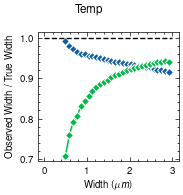

In [60]:
import scienceplots

plt.style.use(['science','nature'])

estimation_width_data = all_data.groupby(["True Width", "Imaging Modality", "Wavelength"], as_index=False).max("Depth of Focus").query("Wavelength == 0.6")
estimation_width_data = all_data[np.isclose(all_data["Depth of Focus"], all_data["True Width"], rtol=0.05)].query("Wavelength == 0.5")


fig, WIDTH_DEPENDENCE = plt.subplots(1, 1, figsize = (2,2))


sns.lineplot(data = estimation_width_data, x = "True Width", y = "Observed Width / True Width", hue = "Imaging Modality", marker="D", markersize=4, legend = None)
plt.xlabel("Width ($\mu m$)")
plt.plot([0,3],[1,1],color = "k", linestyle="--")

plt.suptitle("Temp")

plt.tight_layout()

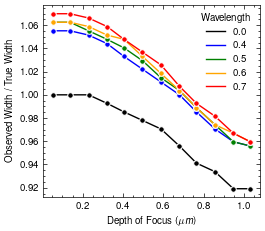

In [61]:
plt.figure(figsize=(2.8,2.5))
sns.lineplot(x="Depth of Focus", y="Observed Width / True Width", hue = "Wavelength",
     data=standard_cell.query("`Imaging Modality` == 'FL'"), palette=wavelength_colours, marker= "o", markersize=4)
#plt.title("Width = 1, Imaging Modality = FL")
plt.xlabel("Depth of Focus ($\mu m$)")
plt.savefig("FL_wavelength.pdf")

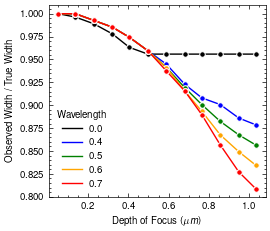

In [56]:
plt.figure(figsize=(2.8,2.5))
sns.lineplot(x="Depth of Focus", y="Observed Width / True Width", hue = "Wavelength",
     data=standard_cell.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, marker= "o", markersize=4)
#plt.title("Width = 1, Imaging Modality = Membrane")
plt.xlabel("Depth of Focus ($\mu m$)")
plt.savefig("membrane_wavelength.pdf")

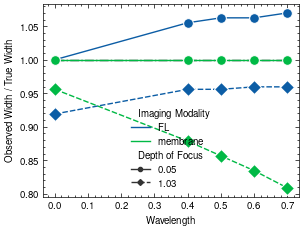

In [50]:
max_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].max()
min_dof_FL = standard_cell.query("`Imaging Modality` == 'FL'")["Depth of Focus"].min()
high_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @max_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_FL = standard_cell.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @min_dof_FL").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()

max_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].max()
min_dof_membrane = standard_cell.query("`Imaging Modality` == 'membrane'")["Depth of Focus"].min()
high_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()
low_dof_wavelength_membrane = standard_cell.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @min_dof_membrane").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()



high_low_dof = pd.concat([high_dof_wavelength_FL, low_dof_wavelength_FL, high_dof_wavelength_membrane, low_dof_wavelength_membrane])
plt.plot([0,0.7],[1,1], c="k", linestyle="-.")
p = sns.lineplot(x = "Wavelength", y = "Observed Width / True Width", data = high_low_dof, style = "Depth of Focus", hue = "Imaging Modality", markers = ["o", "D"], markersize=7,)
leg = p.legend_
for t in leg.texts:
    if any([x in t.get_text() for x in ["Imag", "FL", "memb", "Depth"]]):
        pass
    else:
    # truncate label text to 4 characters
        t.set_text(t.get_text()[:4])

plt.savefig("wavelength.pdf")

In [25]:
imshow_data = all_data.loc[high_low_dof.index]

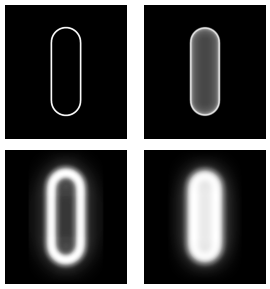

In [26]:
##00 = proj, diff
fig, axs = plt.subplots(2,2, figsize = (3,3))
mem_00, mem_10, mem_01, mem_11 = axs.flatten()

mem_00.imshow( np.load(imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

mem_10.imshow( np.load(imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

mem_01.imshow( np.load(imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0.7 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

mem_11.imshow( np.load(imshow_data.query("`Imaging Modality` == 'membrane' & Wavelength == 0.7 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

for ax in axs.flatten():
    ax.axis("off")
plt.tight_layout()
plt.savefig("membrane_imshow.pdf")

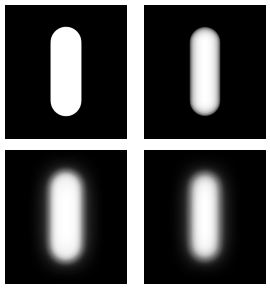

In [27]:
##00 = proj, diff
fig, axs = plt.subplots(2,2, figsize = (3,3))
FL_00, FL_10, FL_01, FL_11 = axs.flatten()

FL_00.imshow(  np.load(imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

FL_10.imshow(  np.load(imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

FL_01.imshow(  np.load(imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0.7 & `Depth of Focus` == @min_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

FL_11.imshow(  np.load(imshow_data.query("`Imaging Modality` == 'FL' & Wavelength == 0.7 & `Depth of Focus` == @max_dof_membrane")["filename"].iloc[0])[200:-200,:], cmap="Greys_r" )

for ax in axs.flatten():
    ax.axis("off")
plt.tight_layout()
plt.savefig("FL_imshow.pdf")

In [28]:
profiles = []
for index, row in imshow_data.iterrows():
    profiles.append(row["profile"])

max_int = np.max(profiles)
#profiles[0] = profiles[0]/profiles[0].max() * max_int

profiles = [x/x.max() * max_int for x in profiles]

x_axes = []
for plot_profile in profiles:
    x_axis = np.arange(0,len(plot_profile),1).astype(float)
    x_axis -= x_axis.max()/2
    x_axis *= pix_mic_conv
    x_axes.append(x_axis)

imshow_data["profile"] = profiles
imshow_data["x axis"] = x_axes
imshow_data = imshow_data.explode(["profile", "x axis"])

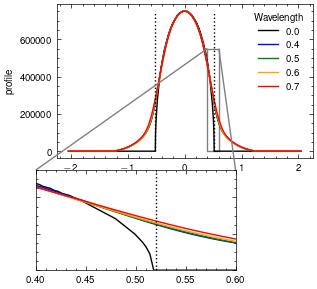

In [29]:
fig, ax = plt.subplots(1,1, figsize = [3.3, 2.])
sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                     data=imshow_data.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = ax)
width = imshow_data["True Width"].unique()[0]

axins1 = inset_axes(ax, 2 ,1, "center", bbox_to_anchor=(120,-40)) #zoomed_inset_axes(ax, 5, loc="lower center", bbox_to_anchor=(10,-100))

mark_inset(ax, axins1, loc1=2, loc2=1, fc="none", ec="0.5")
sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                     data=imshow_data.query("`Imaging Modality` == 'FL' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = axins1, legend=None)
axins1.set_xlim([0.4,0.6])
axins1.set_ylim([0*10**5, 5.5*10**5])
axins1.set_xlabel(None)
axins1.set_ylabel(None)
axins1.set_yticklabels([])
axins1.set_yticklabels([])
ax.plot([width/2,width/2], [0, 750000], c = "k", linestyle=":")
ax.plot([-width/2,-width/2], [0, 750000], c = "k", linestyle=":")

axins1.plot([width/2,width/2], [0, ax.get_ylim()[1]], c = "k", linestyle=":")

ax.set_xlabel("Profile (micron)")
#plt.tight_layout()
plt.savefig("FL_profile.pdf",bbox_inches='tight' )

/tmp/ipykernel_713853/887670624.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


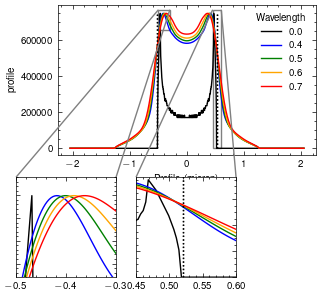

In [30]:
fig, ax = plt.subplots(1,1, figsize = [3.3, 2.])

sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                     data=imshow_data.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = ax)


axins1 = inset_axes(ax, 1 ,1, "center", bbox_to_anchor=(190,-33)) #zoomed_inset_axes(ax, 5, loc="lower center", bbox_to_anchor=(10,-100))

mark_inset(ax, axins1, loc1=2, loc2=1, fc="none", ec="0.5")
sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                     data=imshow_data.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = axins1, legend=None)
axins1.set_xlim([0.45,0.6])
axins1.set_ylim([0*10**5, 7.7*10**5])
axins1.set_xlabel(None)
axins1.set_ylabel(None)
axins1.set_yticklabels([])
axins1.set_yticklabels([])
ax.plot([width/2,width/2], [0, 760000], c = "k", linestyle=":")
ax.plot([-width/2,-width/2], [0, 760000], c = "k", linestyle=":")

axins1.plot([width/2,width/2], [0, ax.get_ylim()[1]], c = "k", linestyle=":")

ax.set_xlabel("Profile (micron)")


axins2 = inset_axes(ax, 1 ,1, "center", bbox_to_anchor=(70,-33)) #zoomed_inset_axes(ax, 5, loc="lower center", bbox_to_anchor=(10,-100))

mark_inset(ax, axins2, loc1=1, loc2=2, fc="none", ec="0.5")
sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                     data=imshow_data.query("`Imaging Modality` == 'membrane' & `Depth of Focus` == @max_dof_membrane"), palette=wavelength_colours, ax = axins2, legend=None)
axins2.set_xlim([-0.5, -0.3])
axins2.set_ylim([6.6*10**5, 7.7*10**5])
axins2.set_xlabel(None)
axins2.set_ylabel(None)
axins2.set_yticklabels([])
axins2.set_yticklabels([])
ax.plot([width/2,width/2], [0, 760000], c = "k", linestyle=":")
ax.plot([-width/2,-width/2], [0, 760000], c = "k", linestyle=":")

axins1.plot([width/2,width/2], [0, ax.get_ylim()[1]], c = "k", linestyle=":")

ax.set_xlabel("Profile (micron)")
plt.tight_layout()
plt.savefig("membrane_profile.pdf",bbox_inches='tight' )

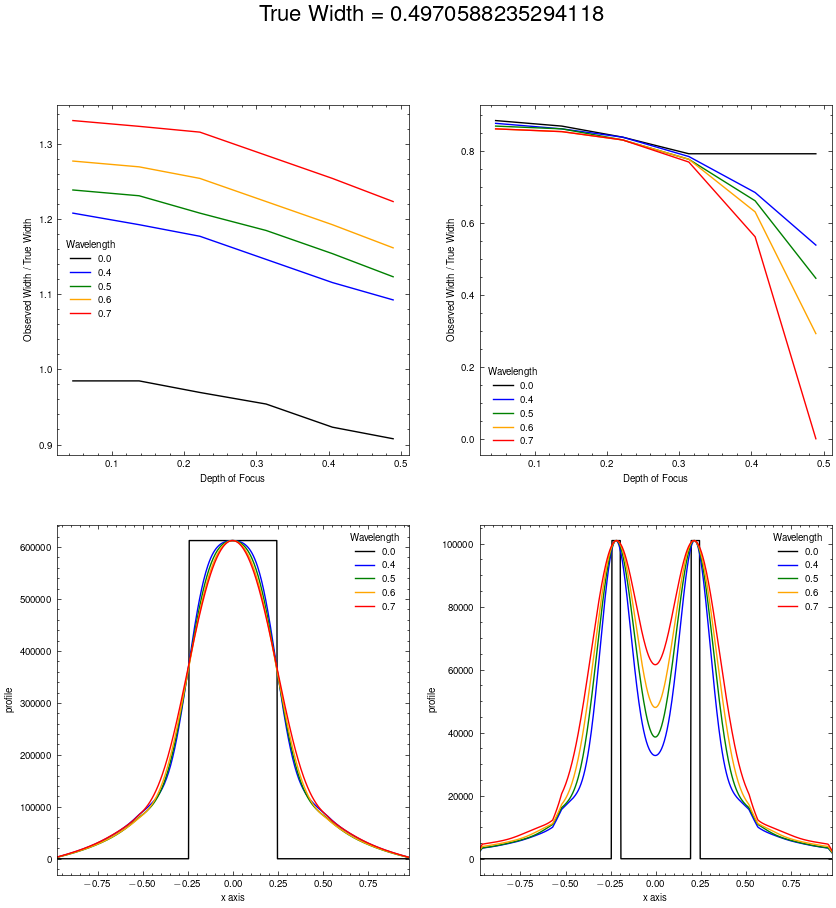

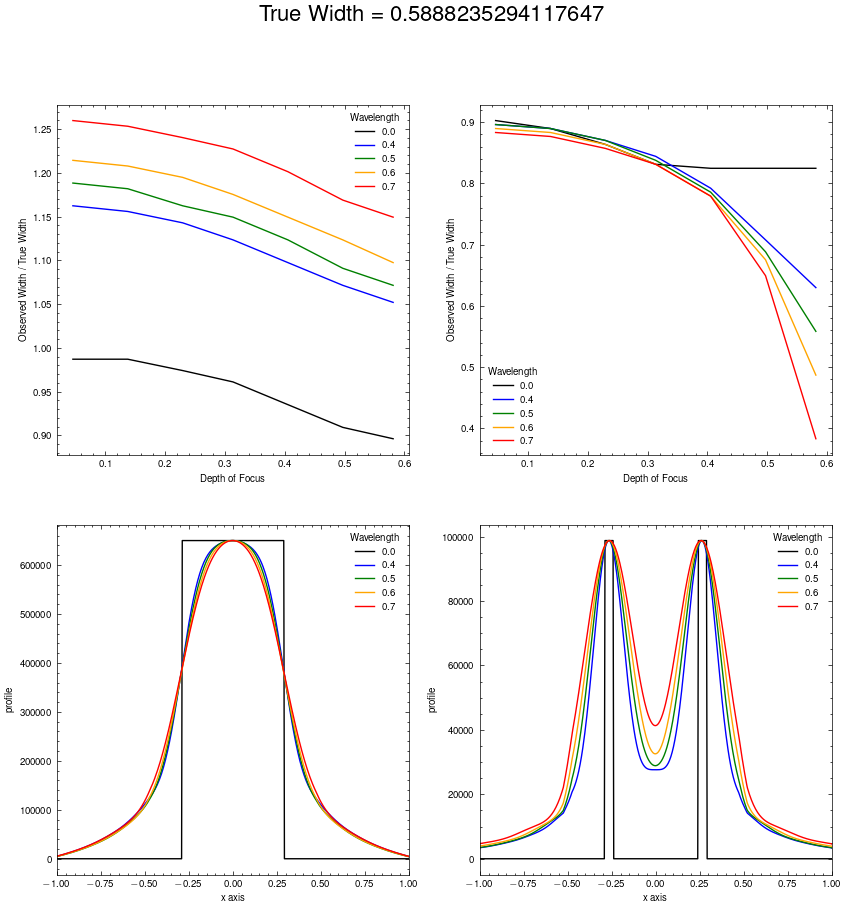

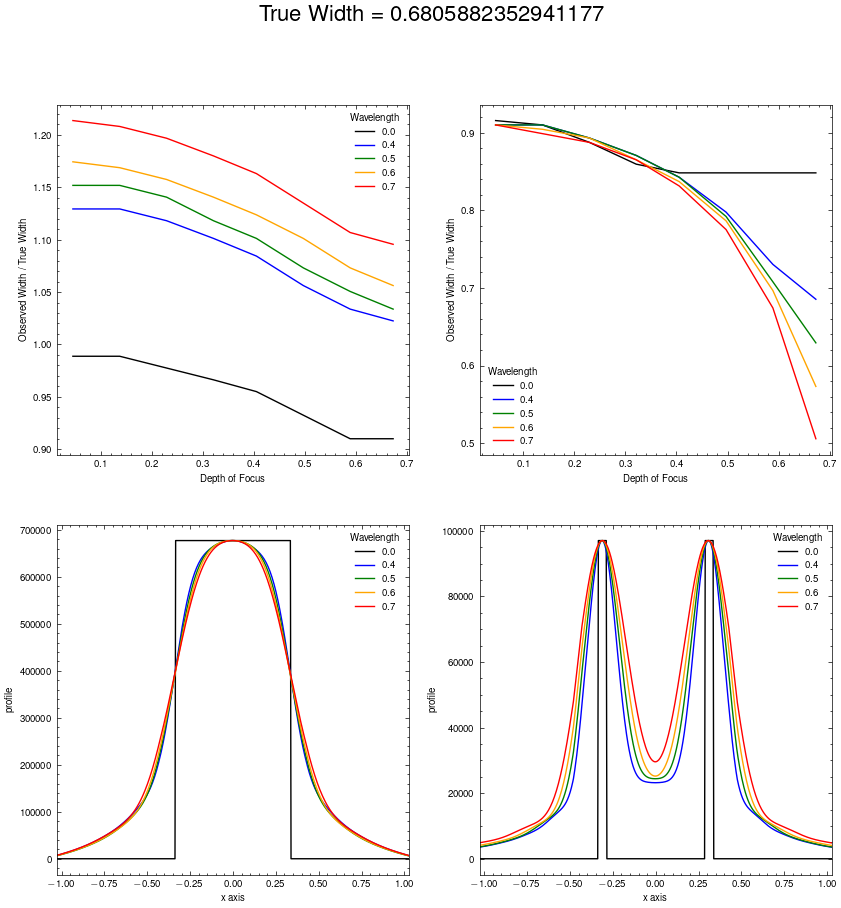

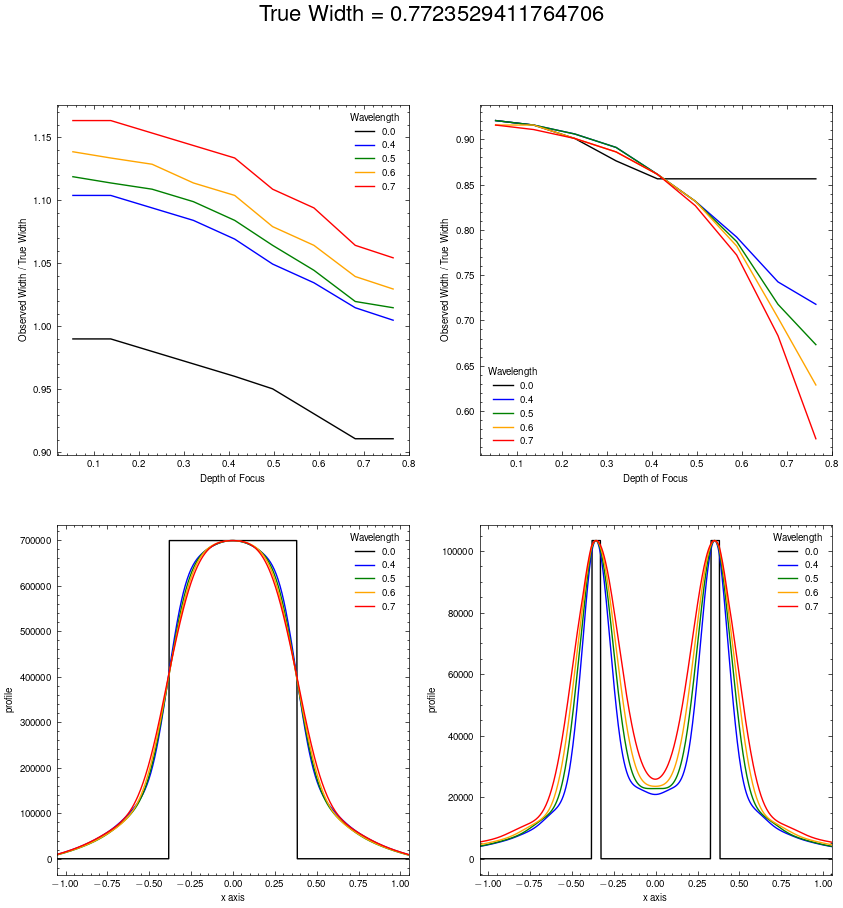


KeyboardInterrupt



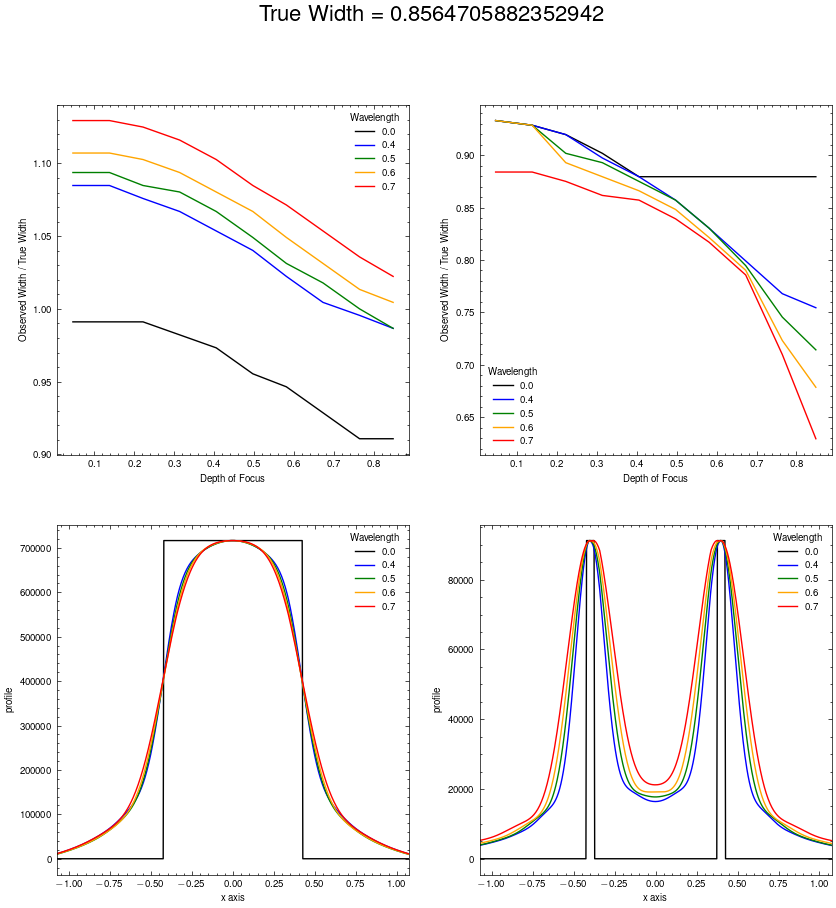

In [31]:
# Plot the responses for different events and regions
for width in sorted(all_data["True Width"].unique()):
    width_data = all_data[ (all_data["True Width"] == width) ]
    
    fig, axs = plt.subplots(2,2, figsize = (10,10))
    if (len(width_data) > 0):
        
        sns.lineplot(x="Depth of Focus", y="Observed Width / True Width", hue = "Wavelength",
             data=width_data.query("`Imaging Modality` == 'FL'"), palette=wavelength_colours, ax = axs.flatten()[0])
        
        sns.lineplot(x="Depth of Focus", y="Observed Width / True Width", hue = "Wavelength",
             data=width_data.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, ax = axs.flatten()[1])
        
        #g = sns.relplot(x="True Depth", y="Observed Width / True Width",
        #             col="Imaging Modality", hue = "Wavelength", kind="line",
        #             data=width_data, palette=wavelength_colours)
        #g.fig.subplots_adjust(top=0.9)
        #g.fig.suptitle(f"True Width = {width}", fontsize=16)
       
        width_float = width #float(width.split(" ")[2])


        profile_data = pd.DataFrame()
        for modality in ["FL", "membrane"]:
            temp_width_data = width_data[width_data["Imaging Modality"] == modality]

            width_float = width #float(width.split(" ")[2])

            rtol = 1

            max_dof = temp_width_data["Depth of Focus"].min()
            close_depth_to_width = temp_width_data.query("`Depth of Focus` == @max_dof")
            idx = close_depth_to_width.drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates().index
            close_depth_to_width = close_depth_to_width.loc[idx]

            while len(idx) > len(wavelength_colours):
                close_depth_to_width = temp_width_data[np.isclose(temp_width_data["True Depth"], width_float, rtol=rtol)]
                close_depth_to_width = close_depth_to_width.sort_values(by="Wavelength")
                idx = close_depth_to_width.drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates().index
                close_depth_to_width = close_depth_to_width.loc[idx]
                rtol *= 0.9


            all_data_temp = all_data.loc[idx]

            profiles = []
            for index, row in close_depth_to_width.iterrows():
                profiles.append(row["profile"])

            max_int = np.max(profiles)
            #profiles[0] = profiles[0]/profiles[0].max() * max_int

            profiles = [x/x.max() * max_int for x in profiles]

            x_axes = []
            for plot_profile in profiles:
                x_axis = np.arange(0,len(plot_profile),1).astype(float)
                x_axis -= x_axis.max()/2
                x_axis *= pix_mic_conv
                x_axes.append(x_axis)

            all_data_temp["profile"] = profiles
            all_data_temp["x axis"] = x_axes
            profile_data = profile_data.append(all_data_temp)
        profile_data = profile_data.explode(["profile", "x axis"])
        #h = sns.relplot(x="x axis", y="profile",
        #                     col="Imaging Modality", hue = "Wavelength", kind="line", facet_kws={'sharey': False},
        #                     data=profile_data, palette=wavelength_colours)
        
        sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                             data=profile_data.query("`Imaging Modality` == 'FL'"), palette=wavelength_colours, ax=axs.flatten()[2])
        sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                             data=profile_data.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, ax=axs.flatten()[3])
        lims = np.array(axs.flatten()[2].get_xlim())*0.5
        
        axs.flatten()[2].set_xlim(lims)
        axs.flatten()[3].set_xlim(lims)
        
        
        plt.suptitle(f"True Width = {width}", fontsize=16)
        
        plt.savefig(f"diagnostics/{width}.png")
        plt.show()

for paper figure

In [ ]:
# Plot the responses for different events and regions
width = sorted(all_data["True Width"].unique())[5]
width_data = all_data[ (all_data["True Width"] == width) ]
width_float = width #float(width.split(" ")[2])
for_superbug = pd.DataFrame()
profile_data = pd.DataFrame()
fig, axs = plt.subplots(1,4, figsize = (8,6))
imgs_to_plot = []
for i, modality in enumerate(["FL", "membrane"]):
    temp_width_data = width_data[width_data["Imaging Modality"] == modality]

    width_float = width # float(width.split(" ")[2])

    rtol = 1

    #close_depth_to_width = temp_width_data[np.isclose(temp_width_data["True Depth"], width_float, rtol=rtol)]
    #close_depth_to_width = close_depth_to_width.sort_values(by="Wavelength")
    
    max_dof = temp_width_data["Depth of Focus"].min()
    close_depth_to_width = temp_width_data.query("`Depth of Focus` == @max_dof")
    
    idx = close_depth_to_width.drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates().index
    close_depth_to_width = close_depth_to_width.loc[idx]

    while len(idx) > len(wavelength_colours):
        close_depth_to_width = temp_width_data[np.isclose(temp_width_data["True Depth"], width_float, rtol=rtol)]
        close_depth_to_width = close_depth_to_width.sort_values(by="Wavelength")
        idx = close_depth_to_width.drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates().index
        close_depth_to_width = close_depth_to_width.loc[idx]
        rtol *= 0.9


    all_data_temp = all_data.loc[idx]
    for_superbug = for_superbug.append(all_data_temp)
    profiles = []
    for index, row in close_depth_to_width.iterrows():
        profiles.append(row["profile"])

    max_int = np.max(profiles)
    #profiles[0] = profiles[0]/profiles[0].max() * max_int

    profiles = [x/x.max() * max_int for x in profiles]

    x_axes = []
    for plot_profile in profiles:
        x_axis = np.arange(0,len(plot_profile),1).astype(float)
        x_axis -= x_axis.max()/2
        x_axis *= pix_mic_conv
        x_axes.append(x_axis)

    all_data_temp["profile"] = profiles
    all_data_temp["x axis"] = x_axes
    profile_data = profile_data.append(all_data_temp)
    imgs_to_plot.append(np.load(all_data_temp["filename"].iloc[0]))
    if i == 0:
        axs.flatten()[i].imshow((np.load(all_data_temp["filename"].iloc[2])), cmap="Greys_r")
        axs.flatten()[i].axis("off")
        axs.flatten()[i].set_title(modality)
    else:
        axs.flatten()[i+1].imshow((np.load(all_data_temp["filename"].iloc[1])), cmap="Greys_r")
        axs.flatten()[i+1].axis("off")
        axs.flatten()[i+1].set_title(modality)
profile_data = profile_data.explode(["profile", "x axis"])
#h = sns.relplot(x="x axis", y="profile",
#                     col="Imaging Modality", hue = "Wavelength", kind="line", facet_kws={'sharey': False},
#                     data=profile_data, palette=wavelength_colours)

sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                     data=profile_data.query("`Imaging Modality` == 'FL'"), palette=wavelength_colours, ax=axs.flatten()[1])

peaks = find_peaks(profiles[0], distance = 100)[0]

sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                     data=profile_data.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, ax=axs.flatten()[3], legend=None)




# # Plot zoom window 2

#axins1 = zoomed_inset_axes(axs.flatten()[1], 5, loc="center", bbox_to_anchor=(-80,200))
#mark_inset(axs.flatten()[1], axins1, loc1=1, loc2=4, fc="none", ec="0.5")
#sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
#                 data=profile_data.query("`Imaging Modality` == 'FL'"), palette=wavelength_colours, ax=axins1, legend=None)
#axins1.set_xlim([-0.6,-0.4])
#axins1.set_ylim([1*10**7, 3*10**7])
#axins1.set_xlabel(None)
#axins1.set_ylabel(None)
#axins1.set_yticklabels([])
#axins1.set_yticklabels([])



lims = np.array(axs.flatten()[1].get_xlim())*0.5


#axins2 = zoomed_inset_axes(axs.flatten()[3], 4, loc="center", bbox_to_anchor=(800,280))
#mark_inset(axs.flatten()[3], axins2, loc1=2, loc2=3, fc="none", ec="0.5")
#sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
#                 data=profile_data.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, ax=axins2, legend=None)
#axins2.set_xlim([0.25,0.5])
#axins2.set_ylim([1.15*10**7, 1.35*10**7])
#axins2.set_xlabel(None)
#axins2.set_ylabel(None)
#axins2.set_yticklabels([])
#axins2.set_yticklabels([])



#axins = inset_axes(axs.flatten()[3], 1 ,1.5, "center", bbox_to_anchor=(800,100))
#mark_inset(axs.flatten()[3], axins, loc1=2, loc2=3, fc="none", ec="0.5")
# # Plot zoom window
#sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
#                 data=profile_data.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, ax=axins, legend=None)
#axins.set_xlim([0.4,0.5])
#axins.set_ylim([-0.1*10**7, 1.35*10**7])
#axins.set_xlabel(None)
#axins.set_ylabel(None)
#axins.set_yticklabels([])
#axins.set_yticklabels([])
lims = np.array(axs.flatten()[2].get_xlim())*0.5

#axins.plot(    [x_axes[0][peaks[1]],x_axes[0][peaks[1]]]  ,  [0,profiles[0][peaks[1]] ], linestyle = "--")

#axs.flatten()[2].set_xlim(lims)
#axs.flatten()[3].set_xlim(lims)

for ax in [axs.flatten()[3], axs.flatten()[2]]:
    ax.set_ylabel("Intensity")
    ax.set_xlabel("Distance from center (micron)")

plt.suptitle(f"Width = {width}", fontsize=16)
plt.tight_layout()
plt.savefig(f"diagnostics/{width}.png")
plt.show()

In [32]:
sorted(list(all_data_temp["filename"]))

['A_B_single_cells_slice_projection_short_cells.bak/43_membrane_784_224_12_0_0.4.npy',
 'A_B_single_cells_slice_projection_short_cells.bak/43_membrane_784_224_12_0_0.5.npy',
 'A_B_single_cells_slice_projection_short_cells.bak/43_membrane_784_224_12_0_0.6.npy',
 'A_B_single_cells_slice_projection_short_cells.bak/43_membrane_784_224_12_0_0.7.npy',
 'A_B_single_cells_slice_projection_short_cells.bak/43_membrane_784_224_12_0_0.npy']

NameError: name 'imgs_to_plot' is not defined

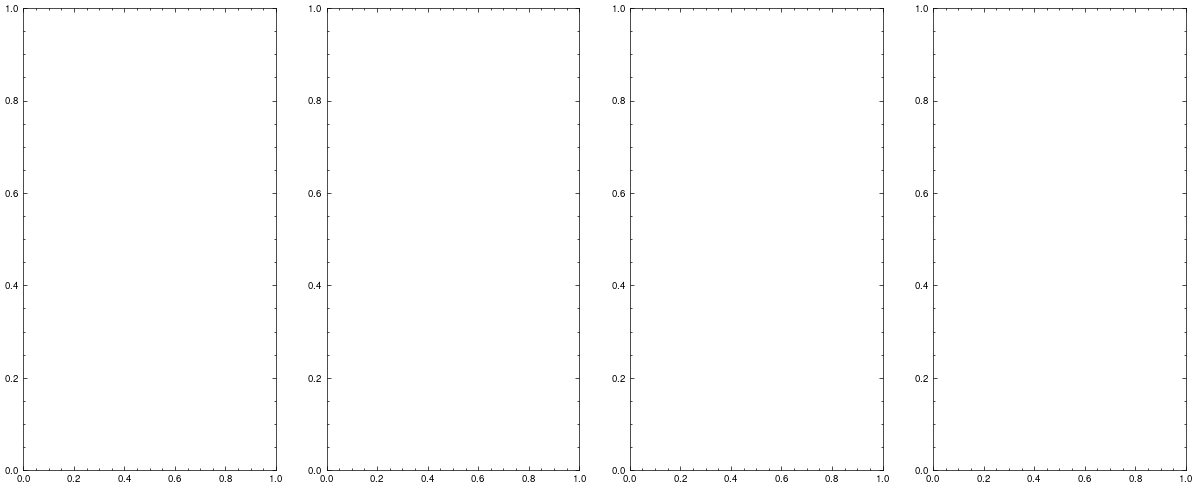

In [33]:
fig, axs = plt.subplots(1,4, figsize = (15,6))

axs[0].imshow( imgs_to_plot[1], cmap="Greys_r")
axs[0].axis("off")
axs[0].set_title("Membrane FL")

sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                     data=profile_data.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, ax=axs[1], legend=None)
lims = np.array(axs[1].get_xlim())*0.5
axs[1].set_xlim(lims)

axins2 = zoomed_inset_axes(axs[1], 3, loc="center", bbox_to_anchor=(575,570))
mark_inset(axs[1], axins2, loc1=3, loc2=4, fc="none", ec="0.5")
sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                 data=profile_data.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, ax=axins2, legend=None)
axins2.set_xlim([-0.45,-0.25])
axins2.set_ylim([1.25*10**7, 1.32*10**7])
axins2.set_xlabel(None)
axins2.set_ylabel(None)
axins2.set_yticklabels([])
axins2.set_yticklabels([])

axins3 = inset_axes(axs.flatten()[1], 1 ,1.5, "center", bbox_to_anchor=(750,350))
mark_inset(axs[1], axins3, loc1=1, loc2=4, fc="none", ec="0.5")
# # Plot zoom window
sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                 data=profile_data.query("`Imaging Modality` == 'membrane'"), palette=wavelength_colours, ax=axins3, legend=None)
axins3.set_xlim([0.4,0.5])
axins3.set_ylim([-0.01*10**7, 1.35*10**7])
axins3.set_xlabel(None)
axins3.set_ylabel(None)
axins3.set_yticklabels([])
axins3.set_yticklabels([])




axs[2].imshow( imgs_to_plot[0], cmap="Greys_r")
axs[2].axis("off")
axs[2].set_title("Cytoplasmic FL")

sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                     data=profile_data.query("`Imaging Modality` == 'FL'"), palette=wavelength_colours, ax=axs[3])
lims = np.array(axs[3].get_xlim())*0.5
axs[3].set_xlim(lims)
axins1 = inset_axes(axs[3], 1, 1, loc="upper left", bbox_to_anchor=(1270,550))
mark_inset(axs.flatten()[3], axins1, loc1=1, loc2=4, fc="none", ec="0.5")
sns.lineplot(x="x axis", y="profile", hue = "Wavelength",
                 data=profile_data.query("`Imaging Modality` == 'FL'"), palette=wavelength_colours, ax=axins1, legend=None)
axins1.set_xlim([0.4,0.5])
axins1.set_ylim([3*10**7, 4*10**7])
axins1.set_xlabel(None)
axins1.set_ylabel(None)
axins1.set_yticklabels([])
axins1.set_yticklabels([])


In [34]:
profiles[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [35]:
some_cell = np.load("A_B_single_cells/0_membrane_1570_130_64_0.0_0.npy")
plt.imshow(some_cell, cmap="Greys_r")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'A_B_single_cells/0_membrane_1570_130_64_0.0_0.npy'

In [36]:
profile = some_cell[:,some_cell.shape[1]//2]
peaks = find_peaks(profile, distance = 100)

plt.plot(profile)
plt.scatter(peaks[0], profile[peaks[0]])
plt.xlim(300,500)

NameError: name 'some_cell' is not defined

In [37]:
np.diff(peaks[0])[0]

NameError: name 'peaks' is not defined

In [38]:
sns.lineplot(x="Wavelength", y="Observed Width / True Width",
             data=for_superbug, style="Imaging Modality", c="k")
plt.xlabel("Wavelength (micron)")

NameError: name 'for_superbug' is not defined

In [39]:
# Plot the responses for different events and regions
for width in sorted(all_data["Width (binned)"].unique()):
    width_data = all_data[ all_data["Width (binned)"] == width ]
    if (len(width_data) > 0):
        sns.relplot(x="True Depth", y="Observed Width / True Width",
                     style="Imaging Modality", hue = "Wavelength", kind="line",
                     data=width_data, palette=wavelength_colours)
        plt.title(f"True Width = {width}")
        plt.show()

KeyError: 'Width (binned)'

In [ ]:
aspect_ratio_matched= all_data[abs(all_data["True Width"] - all_data["True Depth"])/all_data["True Width"] < 0.01]

In [ ]:
# Plot the responses for different events and regions
rp = sns.relplot(x="True Width", y="Observed Width / True Width",
             col="Imaging Modality", hue = "Wavelength", kind="line",
             data=aspect_ratio_matched, palette=wavelength_colours)

rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle("Width = Depth (Perfect spherocylinder)")
plt.savefig("diagnostics/aspect_ratio_matched.png")

In [ ]:
test_data = all_data.query("`True Width` >= `True Depth`  & Wavelength == 0.5 & `True Width` < 1.5").drop(columns = ["profile", "x axis", "ID", "filename"]).drop_duplicates()

In [ ]:
sns.relplot(data = test_data, y = "Observed Width / True Width", x = "True Depth", hue = "True Width", col = "Imaging Modality", kind="line", facet_kws={'sharey': False})

In [ ]:
# Plot the responses for different events and regions
#all_data['Depth (binned)'] = pd.cut(all_data["True Depth"], bins=7, labels=[f'Depth {i}' for i in range(1, 8)])
bins = 7
all_data['Depth (binned)'] = pd.cut(all_data["True Depth"], bins=bins, labels=[f'Depth bin {i:.2f} micron' for i in sorted([x.mid  for x in pd.cut(all_data["True Depth"], bins=bins).unique()]) ])
sns.relplot(x="Width (binned)", y="IoU",
             col="Imaging Modality", hue = "Depth (binned)", kind="line",
             data=all_data)
plt.ylim(0.5,0.6)
plt.xlim(0,0.5)
plt.plot([0,3],[1,1], c = "k", linestyle="--", label="Ground truth")

In [ ]:
# Plot the responses for different events and regions
sns.relplot(x="True Width", y="IoU",
             col="Imaging Modality", hue = "True Depth", kind="line",
             data=all_data[all_data["Imaging Modality"] == "FL"])
plt.ylim(0.7,1)
plt.plot([0,3],[1,1], c = "k", linestyle="--", label="Ground truth")

In [ ]:
# Plot the responses for different events and regions
sns.relplot(x="True Width", y="IoU",
             col="Imaging Modality", hue = "True Depth", kind="line",
             data=all_data)
plt.ylim(0.7,1)
plt.plot([0,3],[1,1], c = "k", linestyle="--", label="Ground truth")